In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm 
from sklearn import preprocessing 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# выписываем данные в датафрейм
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'auto']
df = pd.read_csv("auto-mpg.data", delim_whitespace = True, names = columns)
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,auto
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


In [3]:
# находим категориальные признаки
df.dtypes

# в данном датасете категориальными признаками являются 'name' и 'horsepower'

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
year              int64
origin            int64
auto             object
dtype: object

In [4]:
# проверим названия автомобилей на уникальность
len(df.auto.unique())

# из 398 записей 305 названий машин являются уникальными, в данном случае создавать переменную на каждую марку автомобиля не имеет смысла,
# поэтому можно отбросить данный признак из списка предикторов таргета

305

In [5]:
# проверим есть ли в даных повторяющиеся записи
df.duplicated().sum()

0

In [6]:
# находим в каких столбцах есть пропущенные значения обозначенные "?"
for c in df.columns:
    if df[df[c] == '?'].empty == False:
        print(c)
  
# пустые значения содержатся в столбце 'horsepower'

horsepower


In [7]:
# узнаем в каких строках содержатся пропущенные значения 
df[df.horsepower == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,auto
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


In [8]:
# для дальнейшей работы требуется заполнить пропущенные и перевести значения столбца 'horsepower' в числовой формат
df.horsepower = df.horsepower.replace('?', float('nan')).apply(pd.to_numeric)

# заменим пустые значения на среднее значение по столбцу и округляем до сотых
df.horsepower = df.horsepower.replace(float('nan'), float(df.horsepower.mean()))
df.horsepower = round(df.horsepower, 2)

In [9]:
# изучим статистические данные датасета
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469397,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.199187,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


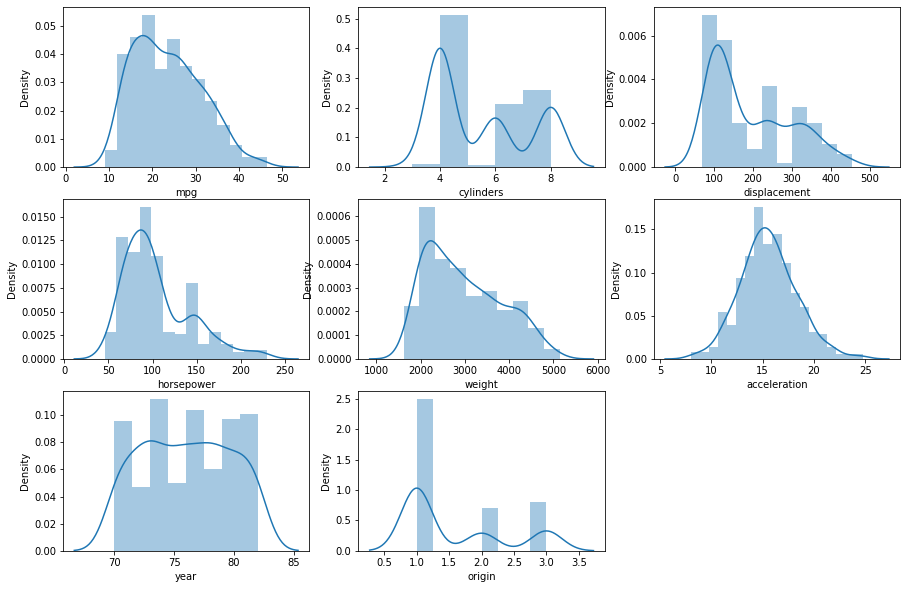

In [10]:
# проверим распределения данных
plt.figure(figsize=(15,10))

for i, column in enumerate(df.columns, 1):
    if column != 'auto':
        plt.subplot(3, 3, i)
        sns.distplot(df[column])

# по гистограммам видно, что у таргет переменной 'mpg' есть небольшой правый хвост, наиболее нормальное распределение у переменной 'acceleration'

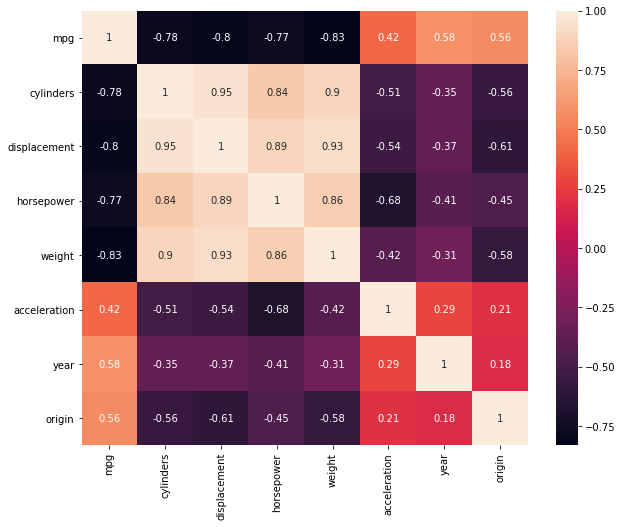

In [11]:
# проверим данные на корреляцию
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot = True)
plt.show()

# из визуализированной confusion матрицы, можно увидеть, что таргет переменная 'mpg' имеет сильную негативную корреляцию 
# с признаками 'cylinders', 'displacement', 'horsepower', 'weight' и среднюю положительную корреляцию с признаками 'year', 'origin'

# кроме того, признаки 'cylinders', 'displacement', 'horsepower', 'weight' образуют мультиколлинеарность,
# в связи с чем требуется убрать часть признаков из списка предикторов

In [12]:
# также можно попробовать добавить в признаки соотношение количества лошадиных сил на вес машины, 
# чтобы узнать насколько хорошо машина преодолевает внешнее сопротивление; это также может иметь влияние на 'mpg'

df['ratio'] = df.horsepower/df.weight

In [13]:
# рассчитаем значения меры VIF для каждого признака, где чем выше значение VIF тем выше мультиколлинеарность фичи с другими независимыми признаками
vif = pd.DataFrame()
features = df[['cylinders', 'acceleration', 'year', 'origin', 'mpg', 'ratio']]
features = sm.tools.add_constant(features) 
vif["Features"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif

# после того, как мы убрали признаки 'horsepower', 'displacement' и 'weight', мы видим что значения понизились до допустимой границы (< 5),
# что говорит о том, что мультиколлинеарность признаков сейчас гораздо ниже

,Features,VIF
0,const,1061.464506
1,cylinders,3.116549
2,acceleration,2.550505
3,year,1.719778
4,origin,1.659856
5,mpg,3.785891
6,ratio,2.179375


In [14]:
# выбираем предикторы и таргет
X = df[['cylinders', 'acceleration', 'year', 'origin', 'ratio']]
y = df['mpg']

In [15]:
# проверям размер предикторов и таргета
X.shape, y.shape

((398, 5), (398,))

In [16]:
# проводим нормализацию признаков
normalizer = MinMaxScaler()
normalizer.fit(X)
X_norm = normalizer.transform(X)
X = pd.DataFrame(data = X_norm, columns = X.columns)
X

,cylinders,acceleration,year,origin,ratio
0,1.0,0.238095,0.0,0.0,0.316002
1,1.0,0.208333,0.0,0.0,0.460762
2,1.0,0.178571,0.0,0.0,0.441209
3,1.0,0.238095,0.0,0.0,0.441937
4,1.0,0.148810,0.0,0.0,0.382684
...,...,...,...,...,...
393,0.2,0.452381,1.0,0.0,0.196122
394,0.2,0.988095,1.0,0.5,0.073661
395,0.2,0.214286,1.0,0.0,0.306468
396,0.2,0.630952,1.0,0.0,0.182195


In [17]:
# делим данные на трейн и тест выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [18]:
# подберем параметры, которые дают наилучшую точность даной модели
parameters = {
    'penalty': ['l1', 'l2'],
    'alpha': [0.01, 0.1, 0.5, 1],
    'max_iter': [1000, 5000, 10000]
}

In [19]:
# создаем линейную регрессию с возможностью регуляризации
model = linear_model.SGDRegressor()

In [20]:
search_model = GridSearchCV(model, parameters, scoring = 'r2', cv = 5, n_jobs = -1, verbose = 7)

In [21]:
search_model.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1],
                         'max_iter': [1000, 5000, 10000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
 

In [22]:
# выведем лучшие найденные параметры
search_model.best_params_

{'alpha': 0.1, 'max_iter': 1000, 'penalty': 'l1'}

In [23]:
# выведем лучшую полученную точность
search_model.best_score_

0.7036719373652207

In [24]:
# построим модель с полученными лучшими параметрами
best_model = linear_model.SGDRegressor(penalty = 'l1', alpha = 0.1, max_iter = 1000)

In [25]:
# оценим предсказание лучшей модели
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

print('R2 score = ', r2_score(y_test, preds))

R2 score =  0.719627925889402
